# GKGZ Postage Stamp Notebook

This notebook produces postage stamps representing the various questions in the GKGZ output results.

In [1]:
# imports
import os
import sys
import copy
import glob
import time
import warnings
import functools
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import (
    AnchoredSizeBar as scalebar
)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter
from scipy.ndimage import gaussian_filter
import astropy.units as u
from astropy.table import Table, join
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import (SkyCoord, match_coordinates_sky)
import multiprocessing

# startup
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor':"w"}
def timecheck(start = None, timefmt = '%Y-%m-%d %H:%M:%S %Z'):
    now = time.time()
    out = time.strftime(timefmt, time.localtime(now))
    if start:
        diff = time.strftime('%H:%M:%S', time.gmtime(now-start))
        out += f' (elapsed: {diff})'
    return [now, out]
nbt0, nbt0str = timecheck()
print(f'Notebook start time:\n   {nbt0str}')
#--------------------------------68-------------------------------->

# one-liners
def seq(a, b, by): return np.arange(a, b + by/2, by)
def npmad(x): return 1.4826*np.nanmedian(np.abs(x-np.nanmedian(x)))
def ddir(x): return [y for y in dir(x) if not y.startswith('__')]
def minmax(x): return [np.nanmin(x), np.nanmax(x)]
def extendrange(x,f=0.05):u,v=minmax(x);d=(v-u)*(1+f);return v-d,u+d
def findin(x, y): return [l for l in list(x) if y in str(l)]
def z2dist(z): return FlatLambdaCDM(70, 0.3).luminosity_distance(z)
def mag2Mag(m, z): return m+5-5*np.log10(z2dist(z).to(u.pc).value)
def stripnan(x): return np.asarray(x)[~np.isnan(x)]
def qindex(a, q): return abs(a - np.percentile(a, q*100)).argmin()

Notebook start time:
   2020-12-03 00:21:57 CST


In [2]:
# input data
cln_file = '../../outputs/gkgz-cleaned.fits.gz'
fin_file = '../../outputs/gkgz-final.fits.gz'
cln = Table.read(cln_file)
fin = Table.read(fin_file)
dat = join(fin, cln, keys='CATAID', join_type='left',
           metadata_conflicts='silent')
pngdir = 'pngs'
vfzdir = 'vfz'
fposdir = 'fpos'
fnegdir = 'fneg'
for outdir in [pngdir, vfzdir, fposdir, fnegdir]:
    if not os.path.exists(outdir):
        os.mkdir(outdir)

In [5]:
# set up bad list (not to be used due to distracting artefacts)
# bads = [23747, 610398, 600014]
bads = [
    23747,  # features_features, z=0.11, vf=0.95
    229201,  # bar_no_bar, z=0.03, vf=0.95
    84377,  # spiralnumber_2, z=0.07, vf=0.95
    560883,  # oddtype_dust_lane, z=0.07, vf=0.50
    54237,  # discuss_yes, z=0.11, vf=0.50
    106704,  # discuss_no, z=0.03, vf=0.95
]
goods = [True if cataid not in bads else False
         for cataid in dat['CATAID']]

In [6]:
# input question/answer list
qas = [x[:-9] for x in dat.colnames if 'deb_frac' in x]

In [8]:
# VFZ: generate PNG list
z_all = dat['Z_TONRY']
z_bins = seq(0, 0.16, 0.02)
z_mids = np.median([z_bins[:-1], z_bins[1:]], axis=0)
# quants = [0.8, 0.5, 0.2]
vf_mids = [0.95, 0.80, 0.65, 0.50]
qa_cataids = []
for qa in qas:
    cataids = []
    for ii, zz in enumerate(z_mids):
        samp = ((z_all >= z_bins[ii]) & (z_all <= z_bins[ii+1])
                & (dat[f'{qa}_deb_frac'] >= 0.5) & goods)
        vf_cln = dat[f'{qa}_clean_frac'][samp]
        vf_deb = dat[f'{qa}_deb_frac'][samp]
        cataid_samp = dat[f'CATAID'][samp]
        if len(vf_deb) > 0:
            idx = []
            if qa == 'mergers_both':
                import ipdb; ipdb.set_trace()
            for vv in vf_mids:
                offset = np.abs(vf_deb - vv)
                if(np.min(offset) < (vf_mids[0]-vf_mids[1])/2):
                    idx.append(np.argmin(offset))
                else:
                    idx.append(-1)
            for idi in idx:
                if idi >= 0:
                    cataids.append(cataid_samp[idi])
                else:
                    cataids.append(0)
        else:
            _ = [cataids.append(0) for x in vf_mids]
    cataids = list(np.ravel(cataids))
    qa_cataids.append(cataids)

In [40]:
# VFZ: get PNGS from the web
# username = 'username'
# password = 'password'
import requests
qa_cataids_flat = [item for sub in qa_cataids for item in sub]
for ii, cataid in enumerate(np.ravel(qa_cataids_flat)):
    if cataid != 0:
        print(f'\r{ii+1}/{len(np.ravel(qa_cataids_flat))}: '
              f'{cataid}   ',
              end='', flush=True)
        row = np.where(dat['CATAID'] == cataid)[0][0]
        webpng = dat[row]['URL_NATIVE_424']
        outpng = f'{pngdir}/G{cataid}-native.png'
        if not os.path.exists(outpng):
            r = requests.get(webpng)  #, auth=(username,password))
            if r.status_code == 200:
                with open(outpng, 'wb') as out:
                    for bits in r.iter_content():
                        out.write(bits)

1248/1248: 584209    

--------------------------------------------------------------------
features_smooth
---------------


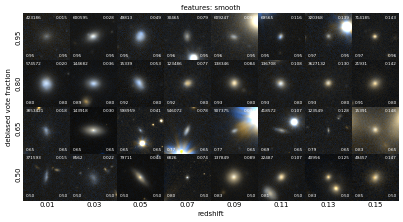

--------------------------------------------------------------------
features_features
-----------------


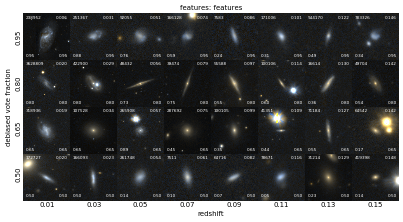

--------------------------------------------------------------------
features_star_or_artifact
-------------------------


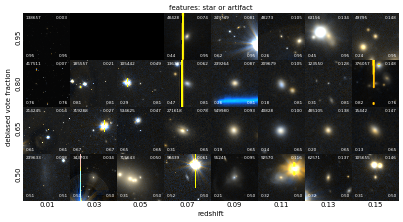

--------------------------------------------------------------------
edgeon_yes
----------


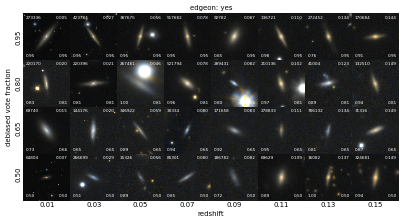

--------------------------------------------------------------------
edgeon_no
---------


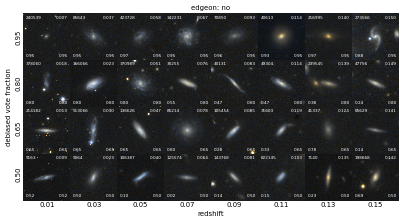

--------------------------------------------------------------------
bar_bar
-------


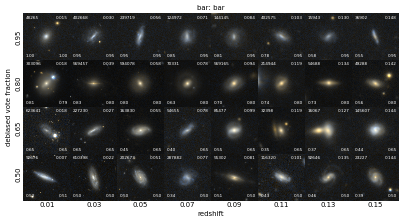

--------------------------------------------------------------------
bar_no_bar
----------


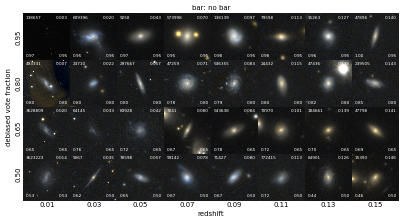

--------------------------------------------------------------------
spiral_spiral
-------------


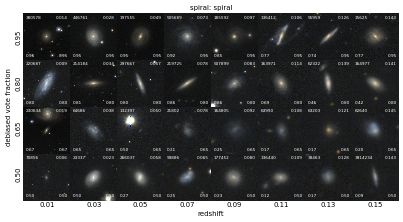

--------------------------------------------------------------------
spiral_no_spiral
----------------


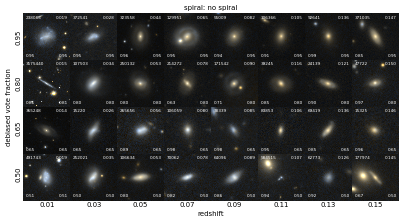

--------------------------------------------------------------------
bulge_no_bulge
--------------


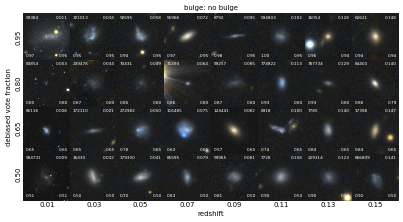

--------------------------------------------------------------------
bulge_obvious
-------------


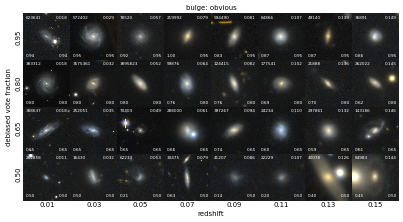

--------------------------------------------------------------------
bulge_dominant
--------------


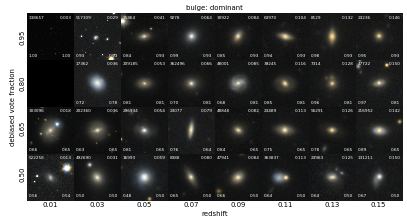

--------------------------------------------------------------------
spiralwinding_tight
-------------------


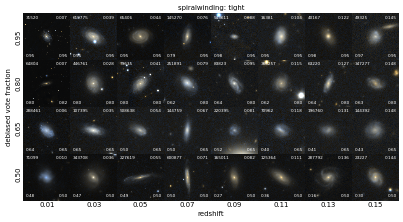

--------------------------------------------------------------------
spiralwinding_medium
--------------------


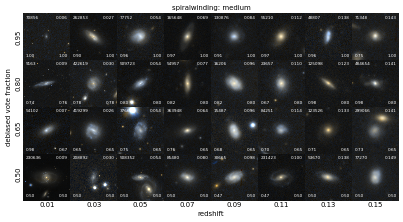

--------------------------------------------------------------------
spiralwinding_loose
-------------------


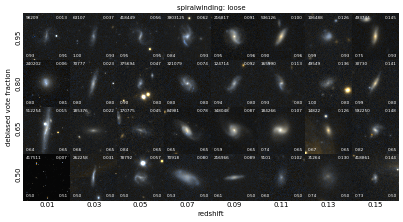

--------------------------------------------------------------------
spiralnumber_1
--------------


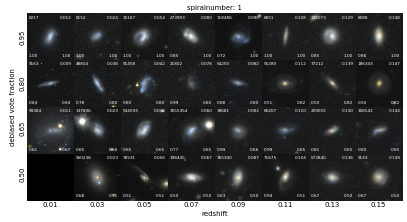

--------------------------------------------------------------------
spiralnumber_2
--------------


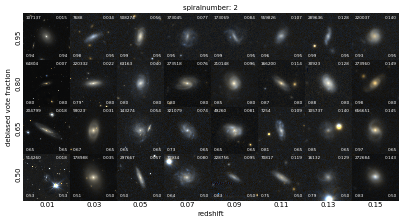

--------------------------------------------------------------------
spiralnumber_3
--------------


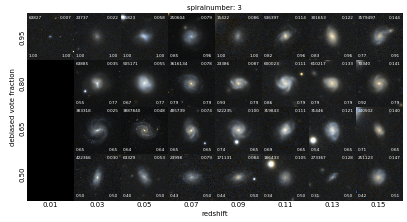

--------------------------------------------------------------------
spiralnumber_4
--------------


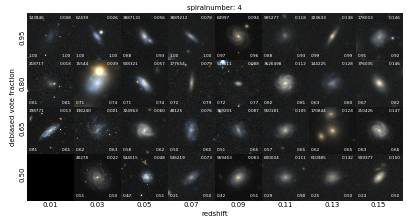

--------------------------------------------------------------------
spiralnumber_more_than_4
------------------------


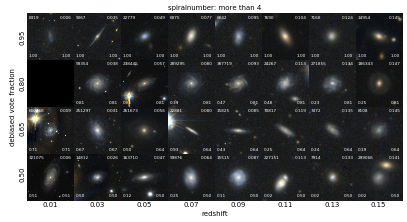

--------------------------------------------------------------------
bulgeshape_rounded
------------------


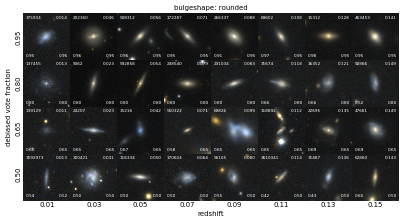

--------------------------------------------------------------------
bulgeshape_boxy
---------------


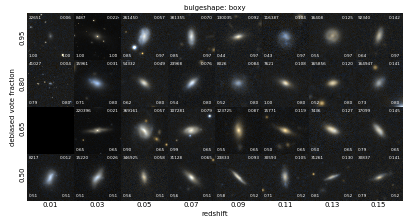

--------------------------------------------------------------------
bulgeshape_no_bulge
-------------------


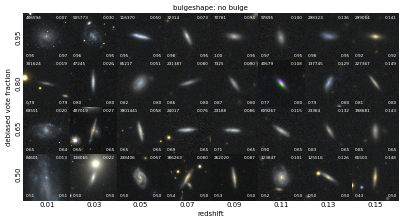

--------------------------------------------------------------------
round_completely_round
----------------------


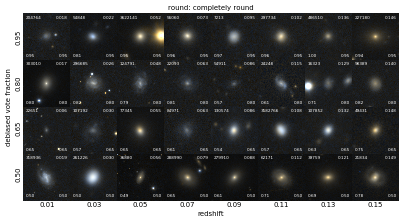

--------------------------------------------------------------------
round_in_between
----------------


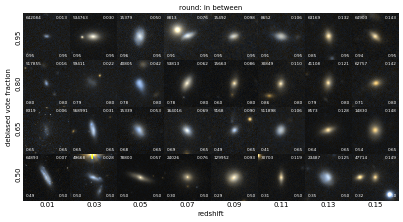

--------------------------------------------------------------------
round_cigar_shaped
------------------


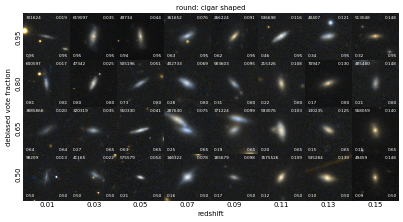

--------------------------------------------------------------------
mergers_merging
---------------


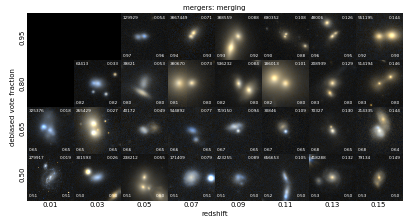

--------------------------------------------------------------------
mergers_tidal_debris
--------------------


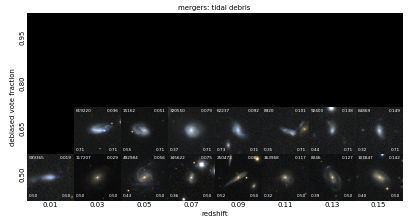

--------------------------------------------------------------------
mergers_both
------------


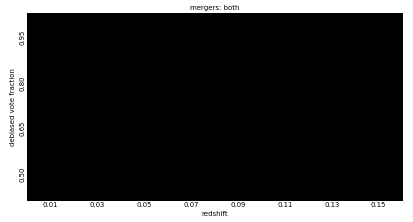

--------------------------------------------------------------------
mergers_neither
---------------


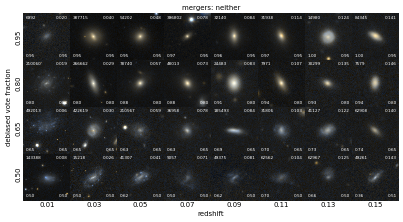

--------------------------------------------------------------------
oddtype_none
------------


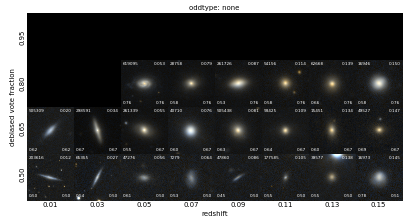

--------------------------------------------------------------------
oddtype_ring
------------


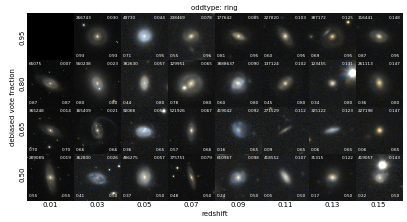

--------------------------------------------------------------------
oddtype_lens_or_arc
-------------------


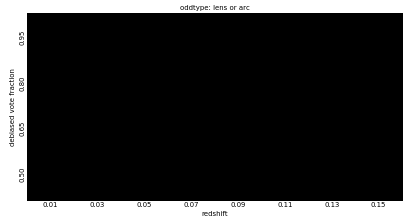

--------------------------------------------------------------------
oddtype_irregular
-----------------


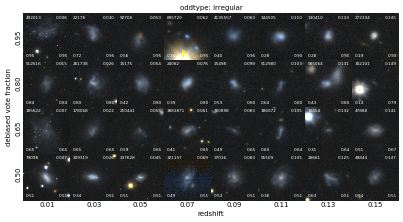

--------------------------------------------------------------------
oddtype_other
-------------


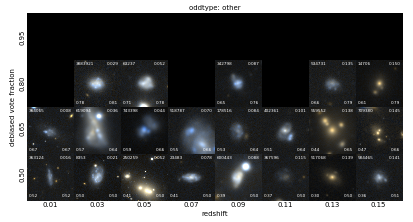

--------------------------------------------------------------------
oddtype_dust_lane
-----------------


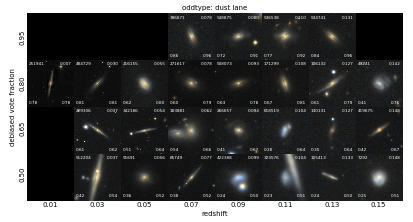

--------------------------------------------------------------------
oddtype_overlapping
-------------------


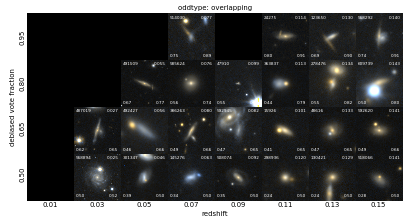

--------------------------------------------------------------------
discuss_yes
-----------


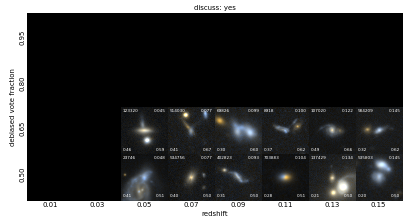

--------------------------------------------------------------------
discuss_no
----------


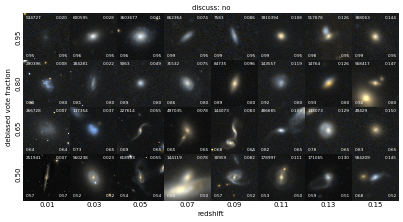

In [41]:
# VFZ: make VF-Z plots
fontsize = 6
inset = 0.05
for qa, qa_list in zip(qas, qa_cataids):
    print('-'*68)
    print(qa)
    print('-'*len(qa))
    fig, axs = plt.subplots(len(vf_mids), len(z_mids),
                            figsize=(8,4.36), dpi=50,
                            gridspec_kw = {'wspace':0, 'hspace':0})
    for ax, cataid in zip(np.ravel(axs.T), np.ravel(qa_list)):
        img = f'{pngdir}/G{cataid}-native.png'
        if os.path.exists(img):
            im = matplotlib.image.imread(img)
        else:
            im = np.array([[[0,0,0]]])
        ax.imshow(im)
        ax.axis('off')
        if os.path.exists(img):
            row = np.where(dat['CATAID'] == cataid)[0][0]
            cc = dat[row][f'{qa}_clean_frac']
            dd = dat[row][f'{qa}_deb_frac']
            zz = dat[row]['Z_TONRY']
            ax.text(inset,1-inset,f'{cataid}',color='white',
                    transform=ax.transAxes, va='top', ha='left',
                    fontsize=fontsize)
            ax.text(1-inset,1-inset,f'{zz:0.3f}',color='white',
                    transform=ax.transAxes, va='top', ha='right',
                    fontsize=fontsize)
            ax.text(inset,inset,f'{cc:0.2f}',color='white',
                    transform=ax.transAxes, va='bottom', ha='left',
                    fontsize=fontsize)
            ax.text(1-inset,inset,f'{dd:0.2f}',color='white',
                    transform=ax.transAxes, va='bottom', ha='right',
                    fontsize=fontsize)
    # axes labelling
    qa_bits = qa.split('_')
    qq = f'{qa_bits[0]}'
    aa = ' '.join(qa_bits[1:])
    plt.text(0.52, 0.965, f'{qq}: {aa}',
            transform=fig.transFigure, ha='center')
    plt.text(0.52, 0.02, f'redshift',
             transform=fig.transFigure, ha='center')
    plt.text(0.008, 0.52, f'debiased vote fraction',
             transform=fig.transFigure, va='center', rotation=90)
    # redshift tick labels
    for xx, zz in zip(np.linspace(0.11,0.93,len(z_mids)),
                      z_mids):
        plt.text(xx, 0.06, f'{zz:.02f}',
                 transform=fig.transFigure, ha='center')
    # deb VF tick labels
    for yy, vv in zip(np.linspace(0.21,0.84,len(vf_mids)),
                      vf_mids[::-1]):
        plt.text(0.0325, yy, f'{vv:.02f}', rotation=90,
                 transform=fig.transFigure, va='center')
    #plt.tight_layout()
    fig.subplots_adjust(left=0.05, right=0.99,
                        bottom=0.09, top=0.95)
    plt.savefig(fname=f'{vfzdir}/vfz_{qa}.png', dpi=300)
    plt.show()  # commented out to reduce saved notebook size
    plt.close()

In [10]:
# remove temporary PNG files after processing
cmd = f'rm -R {pngdir}'
!{cmd}

In [9]:
# Notebook finish up
nbt1, nbt1str = timecheck(nbt0)
print(f'Notebook end time:\n   {nbt1str}')
#--------------------------------68-------------------------------->

Notebook end time:
   2020-12-02 22:03:52 CST (elapsed: 00:01:33)
